# 03 — Classification Modelling
Mục tiêu: train mô hình phân lớp AQI (6 lớp), split theo thời gian, đánh giá bằng accuracy + macro-F1, confusion matrix, và lưu metrics/prediction sample.

In [1]:
DATASET_PATH = 'data/processed/02_dataset_for_clf.parquet'
CUTOFF = '2017-01-01'
METRICS_PATH = 'data/processed/03_metrics.json'
PRED_SAMPLE_PATH = 'data/processed/03_predictions_sample.csv'


In [2]:
# Parameters
DATASET_PATH = "data/processed/02_dataset_for_clf.parquet"
CUTOFF = "2017-01-01"
METRICS_PATH = "data/processed/03_metrics.json"
PRED_SAMPLE_PATH = "data/processed/03_predictions_sample.csv"


In [3]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Tự động tìm PROJECT_ROOT (thư mục chứa src/)
cwd = Path.cwd().resolve()
PROJECT_ROOT = cwd
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise FileNotFoundError("Không tìm thấy thư mục 'src' trong cây thư mục hiện tại.")

# Bảo đảm import được package trong src
sys.path.insert(0, str(PROJECT_ROOT))

from src.classification_library import time_split, train_classifier, AQI_CLASSES

# Chuẩn hoá đường dẫn tuyệt đối
DATASET_PATH = (PROJECT_ROOT / DATASET_PATH).resolve()
METRICS_PATH = (PROJECT_ROOT / METRICS_PATH).resolve()
PRED_SAMPLE_PATH = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()

# Tạo thư mục images để lưu biểu đồ
IMAGES_PATH = PROJECT_ROOT / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Tạo thư mục data/processed để lưu CSV
DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
DATA_PATH.mkdir(parents=True, exist_ok=True)

dataset_path = DATASET_PATH
metrics_path = METRICS_PATH
pred_path = PRED_SAMPLE_PATH
metrics_path.parent.mkdir(parents=True, exist_ok=True)
pred_path.parent.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"dataset_path: {dataset_path}")
print(f"metrics_path: {metrics_path}")
print(f"pred_path: {pred_path}")

PROJECT_ROOT: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries
dataset_path: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\02_dataset_for_clf.parquet
metrics_path: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_metrics.json
pred_path: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_predictions_sample.csv


In [4]:
df = pd.read_parquet(dataset_path)
print('shape:', df.shape)
display(df[['datetime','station','aqi_class']].head())

# Lưu dataset sample
df[['datetime','station','aqi_class']].head(100).to_csv(DATA_PATH / '03_dataset_sample.csv', index=False)
print('Saved:', DATA_PATH / '03_dataset_sample.csv')

shape: (412935, 55)


,datetime,station,aqi_class
0,2013-03-01 17:00:00,Aotizhongxin,Good
1,2013-03-01 18:00:00,Aotizhongxin,Good
2,2013-03-01 19:00:00,Aotizhongxin,Good
3,2013-03-01 20:00:00,Aotizhongxin,Good
4,2013-03-01 21:00:00,Aotizhongxin,Good


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_dataset_sample.csv


In [5]:
train_df, test_df = time_split(df, cutoff=CUTOFF)
print('train:', train_df.shape, '| test:', test_df.shape)
print('test date range:', test_df['datetime'].min(), '->', test_df['datetime'].max())

train: (396264, 55) | test: (16671, 55)
test date range: 2017-01-01 00:00:00 -> 2017-02-28 23:00:00


In [6]:
out = train_classifier(train_df, test_df, target_col='aqi_class')
metrics = out['metrics']
pred_df = out['pred_df']

print('Accuracy:', metrics['accuracy'])
print('F1-macro:', metrics['f1_macro'])
display(pred_df.head())

# Lưu predictions sample
pred_df.head(100).to_csv(DATA_PATH / '03_predictions_sample.csv', index=False)
print('Saved:', DATA_PATH / '03_predictions_sample.csv')

Accuracy: 0.6022434167116549
F1-macro: 0.47153196677178205


,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,Hazardous,Hazardous
1,2017-01-01 01:00:00,Aotizhongxin,Hazardous,Hazardous
2,2017-01-01 02:00:00,Aotizhongxin,Hazardous,Very_Unhealthy
3,2017-01-01 03:00:00,Aotizhongxin,Hazardous,Very_Unhealthy
4,2017-01-01 04:00:00,Aotizhongxin,Hazardous,Hazardous


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_predictions_sample.csv


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\03_confusion_matrix.png


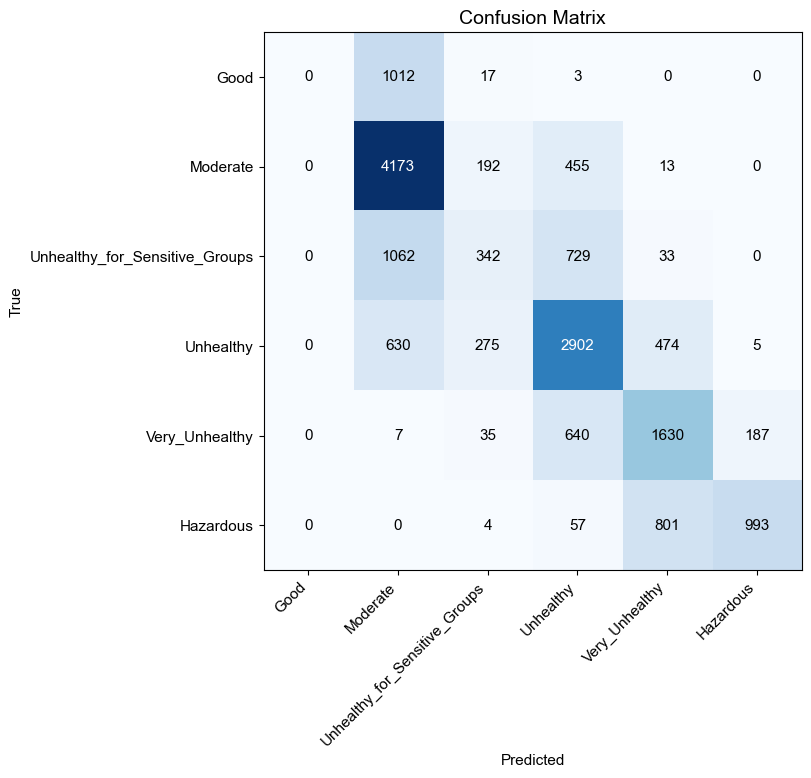

In [7]:
# Confusion matrix plot
cm = np.array(metrics['confusion_matrix'])
labels = metrics['labels']

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix', fontsize=14, fontfamily='Arial')
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=11, fontfamily='Arial')
ax.set_yticklabels(labels, fontsize=11, fontfamily='Arial')
ax.set_xlabel('Predicted', fontsize=11, fontfamily='Arial')
ax.set_ylabel('True', fontsize=11, fontfamily='Arial')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, str(int(cm[i, j])), ha='center', va='center', color=text_color, fontsize=11, fontfamily='Arial')

plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '03_confusion_matrix.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '03_confusion_matrix.png')
plt.show()

In [8]:
# Lưu metrics + sample prediction
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
print('Saved:', metrics_path)
print('Saved:', pred_path)

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_metrics.json
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_predictions_sample.csv


In [9]:
# In classification report (rút gọn)
report = metrics['report']
summary = {k: report[k] for k in ['accuracy', 'macro avg', 'weighted avg'] if k in report}
display(summary)

# Lưu classification report
report_df = pd.DataFrame(report).T
report_df.to_csv(DATA_PATH / '03_classification_report.csv')
print('Saved:', DATA_PATH / '03_classification_report.csv')

{'accuracy': 0.6022434167116549,
 'macro avg': {'precision': 0.4997076103615102,
  'recall': 0.4809987777037216,
  'f1-score': 0.47153196677178205,
  'support': 16671.0},
 'weighted avg': {'precision': 0.5590363071223252,
  'recall': 0.6022434167116549,
  'f1-score': 0.5626572545230011,
  'support': 16671.0}}

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\03_classification_report.csv
